<a href="https://colab.research.google.com/github/kleenman/tds_capstone/blob/main/Kopie_von_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from PIL import Image
from fastai.vision.all import *

In [ ]:
dataset_path = '/content/gdrive/MyDrive/Capstone_split/Data/munich_data'

# define mask function

def mask_function(name):
  img_name = str(name).split('/')[-1]
  mask_path = dataset_path + '/masks/' + img_name.replace('.jpg', '.npy')
  return np.load(mask_path)


In [ ]:
# Create datablock
parks_block = DataBlock(blocks = (ImageBlock, MaskBlock(codes = ['background','park'])),
                 get_items=get_image_files,
                 splitter=RandomSplitter(valid_pct=0.2, seed=42),
                 get_y=mask_function,
                 item_tfms=Resize(500),
                 batch_tfms=aug_transforms(size=500, max_lighting=0.3)
)

# Dataloaders with batch size 4
dls4 = parks_block.dataloaders(dataset_path, bs=4)

# Dataloaders with batch size 16
dls16 = parks_block.dataloaders(dataset_path, bs=16)

# Dataloaders with batch size 32
dls32 = parks_block.dataloaders(dataset_path, bs=32)

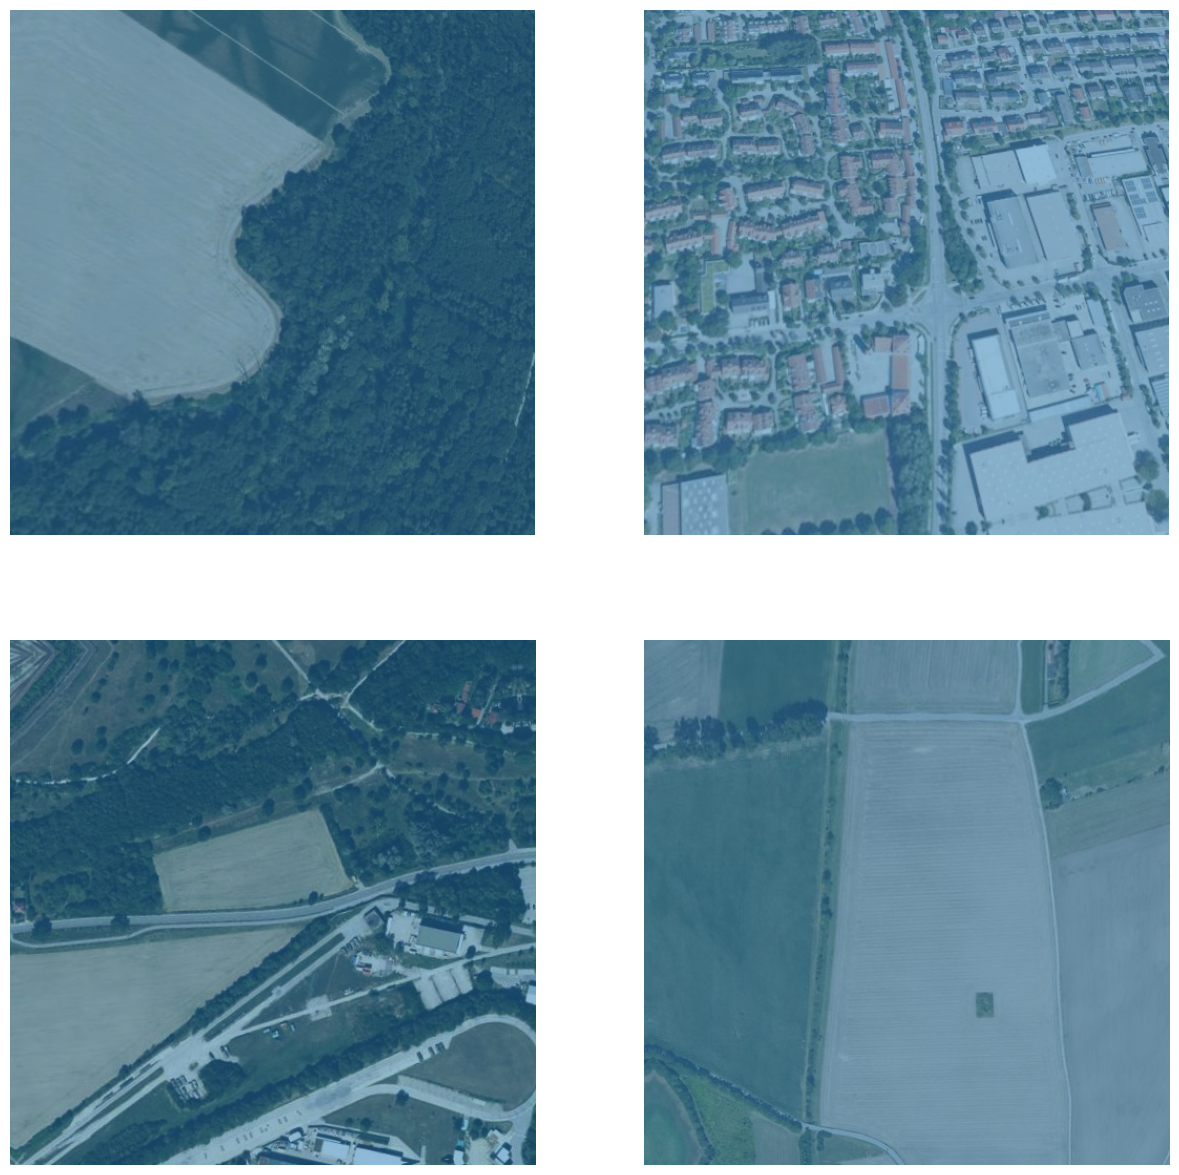

In [ ]:
dls16.show_batch(figsize=(15, 15), max_n=4)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 104MB/s]


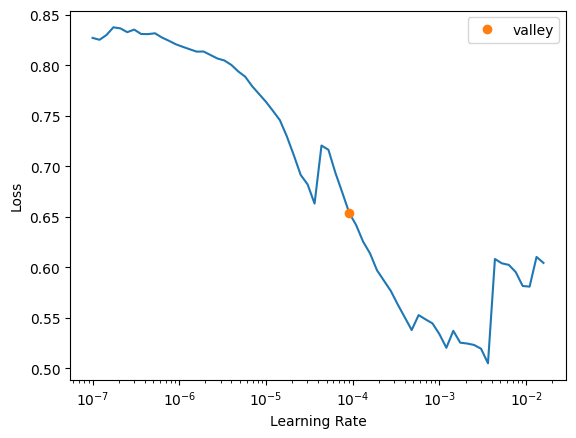

In [ ]:
# Create a U-Net model with batch size 16
learn_bs16 = unet_learner(dls4, resnet34, metrics=Dice)
lr16 = learn_bs16.lr_find()


In [ ]:
learn_bs16.fit_one_cycle(40, lr_max=lr16.valley, cbs=[EarlyStoppingCallback(monitor='dice', min_delta=0.01, patience=10, comp=np.greater),
                                           SaveModelCallback(monitor='dice', min_delta=0.01, comp=np.greater, fname='best_frozen_16')])

epoch,train_loss,valid_loss,dice,time
0,0.267421,0.229760,0.000191,00:56
1,0.245494,0.199021,0.000011,00:52
2,0.261238,0.195118,0.000780,00:50
3,0.227436,0.191522,0.000488,00:51
4,0.238593,0.172317,0.027301,00:50
5,0.228770,0.204616,0.000556,00:51
6,0.217115,0.163133,0.273933,00:51
7,0.193579,0.172898,0.336843,00:51
8,0.196266,0.164680,0.254336,00:51
9,0.203474,0.159947,0.265298,00:51


Better model found at epoch 0 with dice value: 0.00019121533570169944.
Better model found at epoch 4 with dice value: 0.027301130901813932.
Better model found at epoch 6 with dice value: 0.2739333400374634.
Better model found at epoch 7 with dice value: 0.3368426294457798.
Better model found at epoch 10 with dice value: 0.48730804059664273.
Better model found at epoch 16 with dice value: 0.5130331884614688.
Better model found at epoch 18 with dice value: 0.5510282250790004.
Better model found at epoch 20 with dice value: 0.6113323751592035.
No improvement since epoch 20: early stopping


In [ ]:
learn_bs16 = learn_bs16.load('best_frozen_16')
print("in-sample performance: {}".format(np.array(learn_bs16.validate(ds_idx=0)[1])))

/usr/local/lib/python3.10/dist-packages/fastai/learner.py:59: UserWarning: Saved file doesn't contain an optimizer state.
  elif with_opt: warn("Saved file doesn't contain an optimizer state.")


in-sample performance: 0.6781463436338961


In [ ]:
def create_and_train_learner(dl, arch=resnet34, metrics=Dice, monitor='dice', epcohs=40, fname='model', act_cls=torch.nn.modules.activation.ReLU):
  learn = unet_learner(dl, arch, metrics=metrics, act_cls=act_cls)
  lr = learn.lr_find()
  learn.fit_one_cycle(40, lr_max=lr.valley, cbs=[
      EarlyStoppingCallback(monitor=monitor,
                            min_delta=0.01,
                            patience=10,
                            comp=np.greater),
      SaveModelCallback(monitor=monitor,
                        min_delta=0.01,
                        comp=np.greater,
                        fname=fname)])
  return learn

epoch,train_loss,valid_loss,dice,time
0,0.244238,0.214469,0.000000,00:51
1,0.235251,0.243833,0.000000,00:51
2,0.216792,0.178344,0.078860,00:51
3,0.212697,0.177420,0.171712,00:51
4,0.210578,0.178438,0.000002,00:51
5,0.220876,0.170156,0.229884,00:51
6,0.229353,0.167144,0.409174,00:51
7,0.205109,0.175161,0.406184,00:51
8,0.195526,0.166750,0.111879,00:51
9,0.200781,0.151017,0.515876,00:51


Better model found at epoch 0 with dice value: 0.0.
Better model found at epoch 2 with dice value: 0.07885978288968308.
Better model found at epoch 3 with dice value: 0.17171170655190662.
Better model found at epoch 5 with dice value: 0.2298838028122142.
Better model found at epoch 6 with dice value: 0.40917426431855464.
Better model found at epoch 9 with dice value: 0.5158761850150139.
Better model found at epoch 10 with dice value: 0.5455077687098328.
Better model found at epoch 12 with dice value: 0.5640613939486585.
Better model found at epoch 17 with dice value: 0.6089702928086506.
Better model found at epoch 22 with dice value: 0.6391739729275013.
No improvement since epoch 22: early stopping


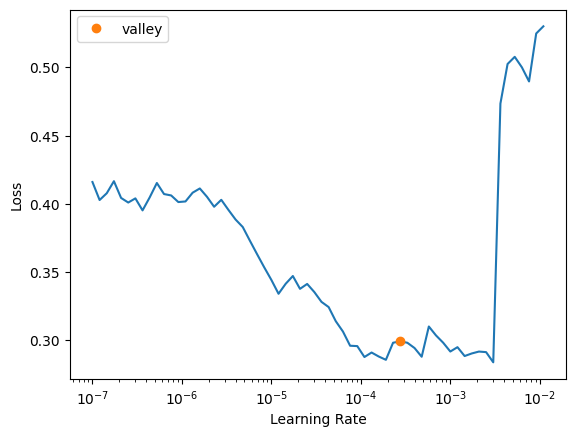

In [ ]:
learn_bs4 = create_and_train_learner(dls4, fname='best_frozen_4') # das hier eingeben

In [ ]:
learn_bs4 = learn_bs4.load('best_frozen_4')
print("in-sample performance: {}".format(np.array(learn_bs4.validate(ds_idx=0)[1])))

in-sample performance: 0.732080458344745


epoch,train_loss,valid_loss,dice,time
0,0.335985,0.263439,0.000955,00:59
1,0.291298,0.243184,0.000118,00:59
2,0.267448,0.224182,0.000014,00:59
3,0.252481,0.211676,0.000018,00:59
4,0.236798,0.183568,0.042677,00:59
5,0.216910,0.191568,0.122464,00:59
6,0.207900,0.165404,0.316467,00:59
7,0.198120,0.178035,0.186030,00:59
8,0.194445,0.162640,0.429086,00:59
9,0.185077,0.184874,0.303506,01:00


Better model found at epoch 0 with dice value: 0.0009552749931601389.
Better model found at epoch 4 with dice value: 0.04267725012299834.
Better model found at epoch 5 with dice value: 0.1224641234484086.
Better model found at epoch 6 with dice value: 0.3164672533911514.
Better model found at epoch 8 with dice value: 0.4290861683616704.
Better model found at epoch 12 with dice value: 0.5222241120810232.
Better model found at epoch 17 with dice value: 0.5537285794685808.
No improvement since epoch 17: early stopping


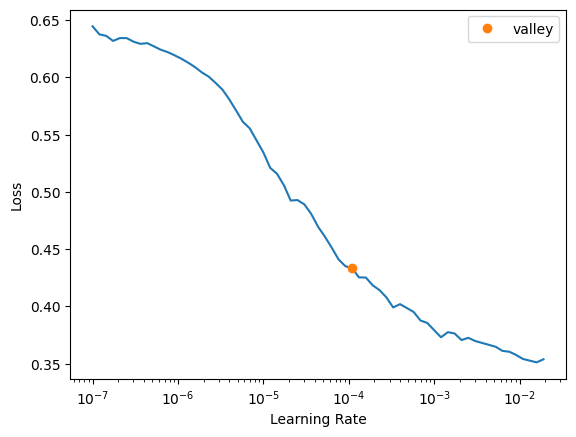

In [ ]:
learn_bs32 = create_and_train_learner(dls32, fname='best_frozen_32')


In [ ]:
learn_bs32 = learn_bs32.load('best_frozen_32')
print("in-sample performance: {}".format(np.array(learn_bs32.validate(ds_idx=0)[1])))

in-sample performance: 0.6617194899026881


In [ ]:
#In Samle vs. Out of Smaple

print("bs 32: out-of-sample performance: {}".format(np.array(learn_bs32.validate(ds_idx=1)[1])))
print("bs 32: in-sample performance: {}".format(np.array(learn_bs32.validate(ds_idx=0)[1])))

print("bs 16: out-of-sample performance: {}".format(np.array(learn_bs16.validate(ds_idx=1)[1])))
print("bs 16: in-sample performance: {}".format(np.array(learn_bs16.validate(ds_idx=0)[1])))

print("bs 4: out-of-sample performance: {}".format(np.array(learn_bs4.validate(ds_idx=1)[1])))
print("bs 4: in-sample performance: {}".format(np.array(learn_bs4.validate(ds_idx=0)[1])))

bs 32: out-of-sample performance: 0.5537285794685808


bs 32: in-sample performance: 0.6668490104505196


bs 16: out-of-sample performance: 0.6113323751592035


bs 16: in-sample performance: 0.6818542697759687


bs 4: out-of-sample performance: 0.6391739729275013


bs 4: in-sample performance: 0.724671618776834


In the next sections we will experiment with different activation functions (ELU, LeakyReLU, GELU) with the U-Net architecture and resnet34 model, while keeping all transformations and batch size constant.


epoch,train_loss,valid_loss,dice,time
0,0.254009,0.240218,0.006072,00:51
1,0.238962,0.203031,0.061100,00:52
2,0.225507,0.192707,0.039017,00:51
3,0.209611,0.176255,0.213463,00:51
4,0.194320,0.176661,0.437410,00:52
5,0.214371,0.162720,0.446233,00:52
6,0.182562,0.153725,0.465062,00:51
7,0.212703,0.172270,0.039984,00:51
8,0.194838,0.159431,0.416707,00:51
9,0.233081,0.207028,0.465793,00:51


Better model found at epoch 0 with dice value: 0.006072346516587996.
Better model found at epoch 1 with dice value: 0.06109971911327331.
Better model found at epoch 3 with dice value: 0.21346323978730972.
Better model found at epoch 4 with dice value: 0.43740971847899685.
Better model found at epoch 6 with dice value: 0.4650615130186608.
Better model found at epoch 13 with dice value: 0.4832503904934122.
Better model found at epoch 14 with dice value: 0.519572338363888.
Better model found at epoch 17 with dice value: 0.5372751985099784.
Better model found at epoch 18 with dice value: 0.5564631385515958.
Better model found at epoch 23 with dice value: 0.6118763630502211.
No improvement since epoch 23: early stopping


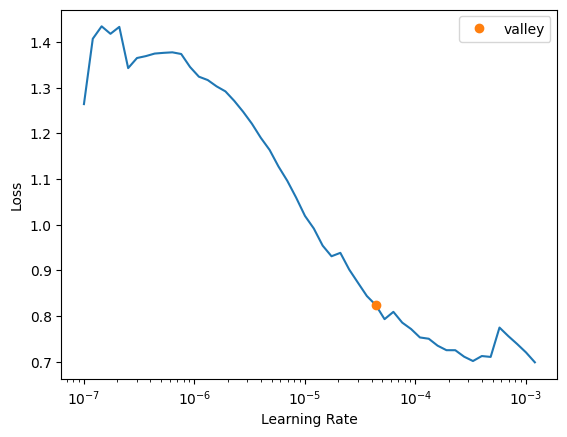

In [ ]:
# Exponential Linear Unit (ELU) activation function:

learn_ELU = create_and_train_learner(dls4, fname='best_frozen_ELU', act_cls=torch.nn.modules.activation.ELU)

The ELU activation function drastically accelerated the learning process of the model. A dice score of over 0.5 was reached as soon as epoch 14 of training, as opposed to the previous model, which used the Rectified Linear Unit activation function, and reached a comparable dice score only after unfreezing its last layers.

In [ ]:
learn_ELU = learn_ELU.load("best_frozen_ELU")
print("in-sample performance: {}".format(np.array(learn_ELU.validate(ds_idx=0)[1])))

/usr/local/lib/python3.10/dist-packages/fastai/learner.py:59: UserWarning: Saved file doesn't contain an optimizer state.
  elif with_opt: warn("Saved file doesn't contain an optimizer state.")


in-sample performance: 0.7293230410367729


In [ ]:
print("out-of-sample performance: {}".format(np.array(learn_ELU.validate(ds_idx=1)[1])))

out-of-sample performance: 0.6118763630502211


The ELU activation function provided slightly better performance than RELU.
Next, we will try the LeakyRELU activation function.

epoch,train_loss,valid_loss,dice,time
0,0.246197,0.219057,0.000001,00:51
1,0.289404,0.237391,0.000000,00:51
2,0.249868,0.222324,0.000000,00:52
3,0.241030,0.197175,0.005329,00:51
4,0.222919,0.177793,0.000001,00:51
5,0.224549,0.196180,0.003187,00:52
6,0.219933,0.159592,0.474957,00:52
7,0.211681,0.157976,0.422985,00:52
8,0.200900,0.183461,0.464231,00:51
9,0.191631,0.143633,0.483059,00:51


Better model found at epoch 0 with dice value: 1.160423523641502e-06.
Better model found at epoch 6 with dice value: 0.47495725280607215.
Better model found at epoch 11 with dice value: 0.48858929395687595.
Better model found at epoch 12 with dice value: 0.522491210022877.
Better model found at epoch 15 with dice value: 0.5532486172303746.


epoch,train_loss,valid_loss,dice,time
0,0.246197,0.219057,0.000001,00:51
1,0.289404,0.237391,0.000000,00:51
2,0.249868,0.222324,0.000000,00:52
3,0.241030,0.197175,0.005329,00:51
4,0.222919,0.177793,0.000001,00:51
5,0.224549,0.196180,0.003187,00:52
6,0.219933,0.159592,0.474957,00:52
7,0.211681,0.157976,0.422985,00:52
8,0.200900,0.183461,0.464231,00:51
9,0.191631,0.143633,0.483059,00:51


Better model found at epoch 18 with dice value: 0.619052179691373.
Better model found at epoch 20 with dice value: 0.6317146788467235.
No improvement since epoch 20: early stopping


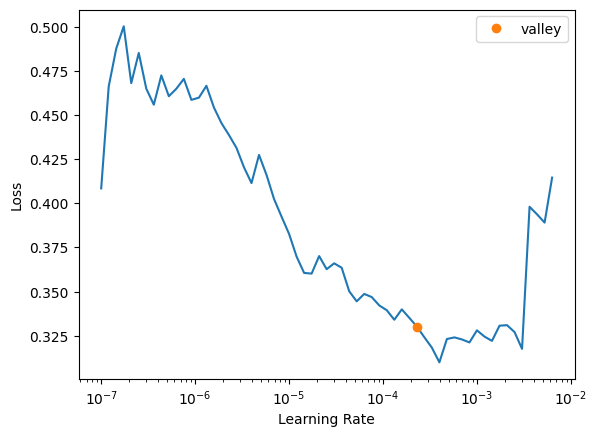

In [ ]:
learn_leaky = create_and_train_learner(dls4, fname='best_frozen_leaky', act_cls=torch.nn.modules.activation.LeakyReLU)

In [ ]:
# safe best model
worst_learner = learn_bs4.load('best_frozen_4')
worst_learner.export('/content/gdrive/MyDrive/Capstone_split/models/worst_model.pkl')

/usr/local/lib/python3.10/dist-packages/fastai/learner.py:59: UserWarning: Saved file doesn't contain an optimizer state.
  elif with_opt: warn("Saved file doesn't contain an optimizer state.")


In [ ]:
learn_leaky = learn_leaky.load("best_frozen_leaky")
print("in-sample performance: {}".format(np.array(learn_leaky.validate(ds_idx=0)[1])))

/usr/local/lib/python3.10/dist-packages/fastai/learner.py:59: UserWarning: Saved file doesn't contain an optimizer state.
  elif with_opt: warn("Saved file doesn't contain an optimizer state.")


in-sample performance: 0.7498006860881131


In [ ]:
print("out-of-sample performance: {}".format(np.array(learn_leaky.validate(ds_idx=1)[1])))

out-of-sample performance: 0.6317146788467235


epoch,train_loss,valid_loss,dice,time
0,0.264065,0.232164,0.000386,00:52
1,0.259557,0.206544,0.002671,00:51
2,0.245852,0.236221,0.000962,00:52
3,0.195100,0.194640,0.004467,00:52
4,0.219284,0.173639,0.124769,00:52
5,0.187136,0.167480,0.071965,00:52
6,0.189925,0.151054,0.363038,00:51
7,0.193105,0.151622,0.426099,00:52
8,0.172734,0.149608,0.386257,00:52
9,0.214171,0.161998,0.465457,00:52


Better model found at epoch 0 with dice value: 0.00038563003656929634.
Better model found at epoch 4 with dice value: 0.12476887183582826.
Better model found at epoch 6 with dice value: 0.36303846373714976.
Better model found at epoch 7 with dice value: 0.4260987982419071.
Better model found at epoch 9 with dice value: 0.4654567061631272.
Better model found at epoch 11 with dice value: 0.49420684417213506.
Better model found at epoch 13 with dice value: 0.583153141918285.
Better model found at epoch 20 with dice value: 0.6232067772108736.
Better model found at epoch 23 with dice value: 0.6392418824701985.
No improvement since epoch 23: early stopping


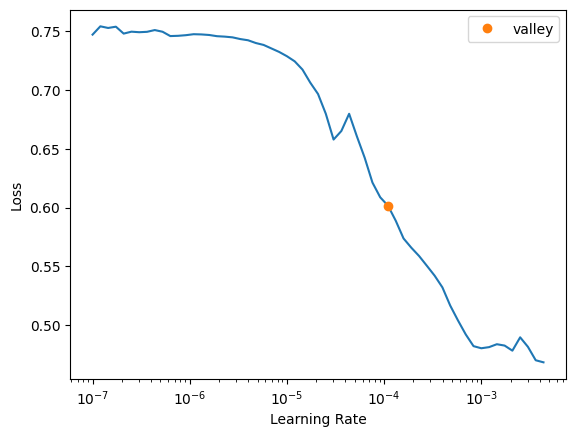

In [ ]:
learn_GELU = create_and_train_learner(dls4, fname='best_frozen_GELU', act_cls=torch.nn.GELU)

In [ ]:
learn_GELU = learn_GELU.load("best_frozen_GELU")
print("in-sample performance: {}".format(np.array(learn_GELU.validate(ds_idx=0)[1])))

in-sample performance: 0.8138716302211004


In [ ]:
print("out-of-sample performance: {}".format(np.array(learn_GELU.validate(ds_idx=1)[1])))

out-of-sample performance: 0.6392418824701985


Finally we will unfreeze and train the last layers of the best model and export it.

we chose GELU because it had the best out of sample performance

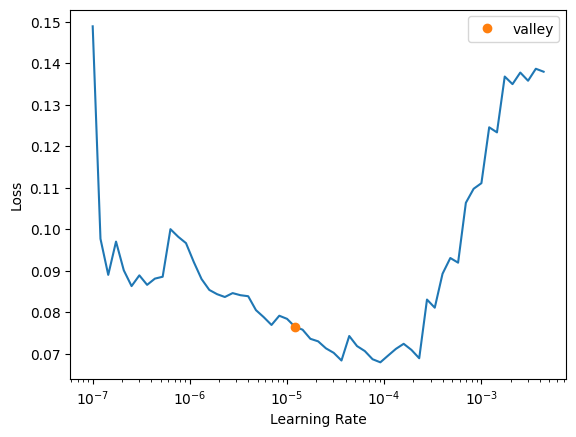

In [ ]:
best_learner = learn_GELU.load('best_frozen_GELU')
best_learner.unfreeze()

best_lr = best_learner.lr_find()

In [ ]:
best_learner.fit_one_cycle(40, lr_max=best_lr.valley, cbs=[EarlyStoppingCallback(monitor='dice', min_delta=0.01, patience=10, comp=np.greater),
                                           SaveModelCallback(monitor='dice', min_delta=0.01, comp=np.greater, fname='best_model')])

epoch,train_loss,valid_loss,dice,time
0,0.082990,0.125390,0.620921,00:54
1,0.083877,0.126800,0.621678,00:53
2,0.075369,0.127524,0.625320,00:54
3,0.079579,0.127016,0.639888,00:54
4,0.072431,0.127890,0.630518,00:54
5,0.081587,0.131201,0.619818,00:54
6,0.076358,0.138837,0.608940,00:54
7,0.081199,0.135605,0.621354,00:53
8,0.074184,0.141305,0.601041,00:53
9,0.068045,0.141628,0.610779,00:53


Better model found at epoch 0 with dice value: 0.6209210507318922.
Better model found at epoch 3 with dice value: 0.6398880512877011.
No improvement since epoch 3: early stopping


In [ ]:
best_learner.export('/content/gdrive/MyDrive/Capstone_split/models/best_model.pkl')

In [ ]:

path = Path('./gdrive/MyDrive/Capstone')
path.ls()

(#7) [Path('gdrive/MyDrive/Capstone/Literature'),Path('gdrive/MyDrive/Capstone/TDS2.pdf'),Path('gdrive/MyDrive/Capstone/Data'),Path('gdrive/MyDrive/Capstone/park_images'),Path('gdrive/MyDrive/Capstone/nopark_images'),Path('gdrive/MyDrive/Capstone/images for gradio'),Path('gdrive/MyDrive/Capstone/best_model.pkl')]

In [ ]:
test_path = '/content/gdrive/MyDrive/Capstone_split/Data/wuerzburg_data'

def test_mask_function(name):
  img_name = str(name).split('/')[-1]
  mask_path = test_path + '/masks/' + img_name.replace('.jpg', '.npy')
  return np.load(mask_path)




In [ ]:
test_block = DataBlock(blocks = (ImageBlock, MaskBlock(codes = ['background','park'])),
                 get_items=get_image_files,
                 get_y=test_mask_function,
                 item_tfms=Resize(460),
                 batch_tfms=aug_transforms(size=256, max_lighting=0.3)
)

test_dls = test_block.dataloaders(test_path, bs=16)

best_model_path = 'gdrive/MyDrive/Capstone_split/models/best_model.pkl'
learn = load_learner(best_model_path)
learn.validate(0, test_dls[0])

(#2) [0.1997072696685791,0.0]